# Provide Input

In [1]:
#Enter number of stocks to be used to create portfolio
n_stocks=6
#Enter risk free rate in Percent
rf=0

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
!pip install yfinance
from scipy.optimize import minimize
import itertools
import yfinance as yf
import seaborn as sb
import matplotlib.pyplot as plt

#Figures Inline and Visualization style
%matplotlib inline
sb.set()

     |████████████████████████████████| 5.5 MB 2.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=84b1169662c4fdd56efe509662b42548837f2c3f0d284ce56118d7a4c80ebd9f
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=f0a1cd641a6dbefeffa6782272e787064fa6ebac6a2ec101235ad5c127eac175
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:
      Successfully uninstalled lxml-4.5.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Load Stock Symbols

In [3]:
#Provide CSV file containing stock symbols and name
data=pd.read_csv('../input/nifty-data/Nifty Stocks.csv', encoding = "ISO-8859-1")
data.head()

,Symbol,Company name
0,MARUTI.NS,Maruti Suzuki India Limited
1,TITAN.NS,Titan Company Limited
2,RELIANCE.NS,Reliance Industries Limited
3,ITC.NS,ITC Limited
4,BHARTIARTL.NS,Bharti Airtel Limited


# Fetch Stock Data From Yahoo Finance

In [4]:
def fetch_data(symbol,name):
    stock=yf.Ticker(symbol)
    data = stock.history(period="6mo",interval='1wk', actions=False)[:-1]
    data.dropna(inplace=True)
    data = data[~data.index.duplicated(keep='first')]
    data[name]=((data.Close/data.Close.shift(1))-1)*100
    data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
    return data

In [5]:
hist=fetch_data('^NSEI','Nifty Returns')

In [6]:
for i in range(len(data)):
    hist=hist.join(fetch_data(data.iloc[i,0],data.iloc[i,1]))
hist.dropna(inplace=True)
hist.drop(columns="Nifty Returns", inplace =True)
hist.tail()

,Maruti Suzuki India Limited,Titan Company Limited,Reliance Industries Limited,ITC Limited,Bharti Airtel Limited,Cipla Limited,Wipro Limited,Larsen & Toubro Limited,ICICI Bank Limited,Tata Consultancy Services Limited
Date,,,,,,,,,,
2021-01-11,0.122897,-4.607386,0.193929,8.114147,11.550213,-1.788482,1.940950,-1.401631,0.175263,3.603132
2021-01-18,0.300322,0.944319,5.788544,-3.282079,-4.281100,-1.869616,1.413751,0.587081,-1.694293,2.351610
2021-01-25,-10.463609,-4.754554,-10.131252,-3.535832,-4.030511,2.177414,-5.825852,-2.011602,0.599478,-5.805153
2021-02-01,3.989371,6.276836,4.440949,15.301356,4.967486,2.639543,1.830580,13.621043,14.366857,1.497737
2021-02-08,2.311139,1.010302,6.858997,-3.371030,2.925486,1.427389,2.690639,0.923178,2.686640,1.521558


# Correlation Matrix of Stocks

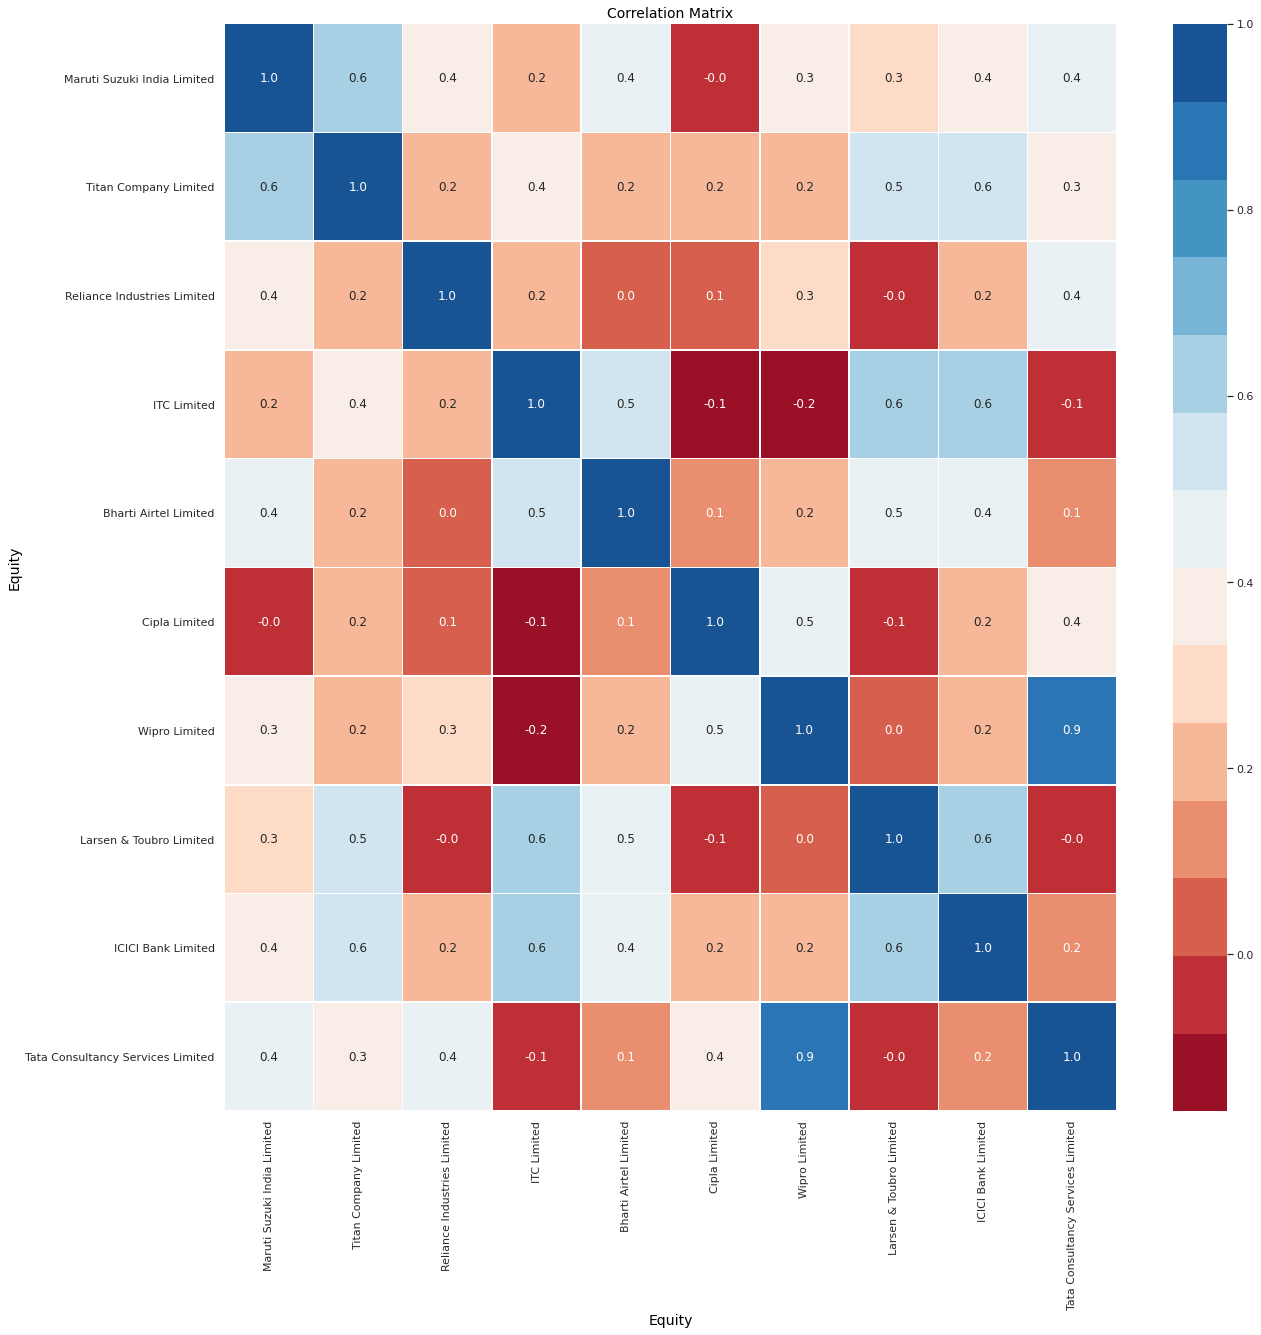

In [7]:
f,ax = plt.subplots(figsize=(20, 20))
sb.heatmap(hist.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=sb.color_palette("RdBu", 14))
ax.set_xlabel('Equity', size=14, color="black")
ax.set_ylabel('Equity', size=14, color="black")
ax.set_title('Correlation Matrix', size=14, color="black")
plt.show()

# Stock Mean, Standard Deviation & Sharpe

In [8]:
stock_data=pd.DataFrame(index=data['Company name'], columns=['Expected Return','Standard Deviation','Sharpe Ratio'])
stock_mean=[]
stock_std=[]
sharpe=[]
for company in data['Company name']:
    stock_mean.append(hist[company].mean())
    stock_std.append(hist[company].std())
stock_data['Expected Return']=stock_mean
stock_data['Standard Deviation']=stock_std
stock_data['Sharpe Ratio']= [(mean-rf)/std for mean, std in zip(stock_mean, stock_std)]
stock_data

,Expected Return,Standard Deviation,Sharpe Ratio
Company name,,,
Maruti Suzuki India Limited,0.705378,4.213056,0.167427
Titan Company Limited,1.323288,3.948902,0.335103
Reliance Industries Limited,-0.022916,4.206485,-0.005448
ITC Limited,0.664880,5.012373,0.132648
Bharti Airtel Limited,0.591543,4.899764,0.120729
Cipla Limited,0.476870,3.594665,0.132660
Wipro Limited,1.911752,5.279237,0.362126
Larsen & Toubro Limited,1.884389,4.462790,0.422245
ICICI Bank Limited,2.313982,5.662954,0.408618


# Optimization

In [9]:
combinations=[]
for subset in itertools.combinations(data.index, n_stocks):
        combinations.append(subset)

In [10]:
#scipy optimization functions
def sharpe(x):
    portfolio_sharpe=((np.array(portfolio)*x).sum(1).mean()-rf)/(np.array(portfolio)*x).sum(1).std()
    return portfolio_sharpe


def constraint(x):
    return sum(x)-1

def objective(x):
    return -sharpe(x)

In [11]:
best_sharpe=-np.inf
for combination in combinations:
    portfolio_allocation=[1/n_stocks]*n_stocks
    portfolio=pd.DataFrame(index=hist.index, columns=[data.iloc[i,1] for i in combination])
    for item in [data.iloc[i,1] for i in combination]: 
        portfolio[item]=hist[item]
    #scipy optimization
    solver=minimize(objective,portfolio_allocation,method='SLSQP',constraints=[{'type':'eq','fun':lambda x:sum(x)-1}],bounds=[(0,1)]*n_stocks,options={'disp':True})
    optimal_allocation=solver.x
    optimal_sharpe=-solver.fun
    if optimal_sharpe>best_sharpe:
        best_sharpe=optimal_sharpe
        best_combination=[data.iloc[i,1] for i in combination]
        best_allocation=optimal_allocation


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.3499805680818764
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.4622326984882952
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.4497299319622445
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.43556580967039804
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.5115910601188474
            Iterations: 6
            Function e

In [12]:
print('Best portfolio is {} with sharpe {}'.format(best_combination,best_sharpe))

Best portfolio is ['Titan Company Limited', 'Reliance Industries Limited', 'Wipro Limited', 'Larsen & Toubro Limited', 'ICICI Bank Limited', 'Tata Consultancy Services Limited'] with sharpe 0.64368449799509


# Best Portfolio & Allocation

In [13]:
optimal_portfolio=pd.DataFrame(columns=['Stock Name', '% Allocation'])
optimal_portfolio['Stock Name']=best_combination
optimal_portfolio['% Allocation']=[str(round(x))+'%' for x in best_allocation*100]
optimal_portfolio

,Stock Name,% Allocation
0,Titan Company Limited,0.0%
1,Reliance Industries Limited,0.0%
2,Wipro Limited,0.0%
3,Larsen & Toubro Limited,33.0%
4,ICICI Bank Limited,10.0%
5,Tata Consultancy Services Limited,57.0%
